<h1 style="font-family: Arial; font-weight: 900; color: magenta; text-align: center;">DIMENSIONALITY REDUCTION</h1><br>

<br/><div style="font-family: Arial; color: darkblue; font-size: 14px; font-weight: 600"><a id="toc"></a>
In this part 5:
    <p style="margin: 0 0 0 2rem; font-size: 16px; font-weight: 800">[1. Principal component analysis](#1)</p>
        <p style="margin: 0 0 0 4rem">[1a. Presentation. The curse of dimensionality](#1a)</p>
        <p style="margin: 0 0 0 4rem">[1b. Understanding Principal Component Analysis](#1b)</p>
        <p style="margin: 0 0 0 4rem">[1c. Coding Principal Component Analysis](#1c)</p>
        <p style="margin: 0 0 0 4rem">[1d. Principal Component Analysis in scikit-learn](#1d)</p><br/>
    <p style="margin: 0 0 0 2rem; font-size: 16px; font-weight: 800">[2. Linear discriminant analysis](#2)</p>
        <p style="margin: 0 0 0 4rem">[2a. Presentation](#2a)</p>
        <p style="margin: 0 0 0 4rem">[2b. The LDA algorithm](#2b)</p>
        <p style="margin: 0 0 0 4rem">[2c. Coding Linear Discriminant Analysis](#2c)</p>
        <p style="margin: 0 0 0 4rem">[2d. Linear Discriminant Analysis in scikit-learn](#2d)</p><br>
    <p style="margin: 0 0 0 2rem; font-size: 16px; font-weight: 800">[3. Nonlinear dimensionality reduction](#3)</p>
        <p style="margin: 0 0 0 4rem">[3a. Presentation](#3a)</p>
        <p style="margin: 0 0 0 4rem">[3b. Example : the t-SNE and UMAP on the Digits dataset](#3b)</p></div>

In [1]:
# Suppresses all logs to avoid pointless warnings
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.manifold import TSNE
import matplotlib.patheffects as PathEffects
# if UMAP is not installed in your environment, simply create a cell
# (eg above this one) and run '!pip install umap-learn'
from umap import UMAP

# The datasets we will use
df_wine = pd.read_csv('wine.data', header=None)
from sklearn.datasets import load_digits

# Beautify code results using colors
from colorama import Fore, Back, Style
# Define some strings for cleaner code
BB = Fore.BLUE + Style.BRIGHT
MB = Fore.MAGENTA + Style.BRIGHT

# Beautify figures by rendering them in SVG quality instead of JPG
# (don't use this if you prefer lightweight notebooks)
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats("svg")
# we'll use the "cyberpunk" color map
cmap = plt.get_cmap("cool")

<a id="1"></a><br><br><br><div style="font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">
    <h4 style="margin: 0 0 .5rem 2rem; font-size: 18px; font-weight: 800"><font color='darkpink'>1. PRINCIPAL COMPONENT ANALYSIS</font></h4>
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>1a. Presentation. The curse of dimensionality</font><a id="1a"></a></p>$\quad$
        The average distance between two points in a unit square is roughly $0.52$; it is roughly $0.66$ in a unit cube; and it grows to about $408.25$ in a $10^6$-dimensional unit hypercube. Hence, datasets with many features tend to be highly spread out, and new instances are likely to lie far from any training point — making predictions much less reliable than in lower dimensions. This phenomenon is known as the <font color='darkpink'>curse of dimensionality</font>.<br>$\quad$
        One might hope to overcome this problem by increasing the number of training instances to achieve sufficient density. Unfortunately, even for $100$ features (and many machine learning tasks involve thousands or millions), the number of required instances for an average spacing below $0.1$ would exceed the number of atoms in the observable universe.<br>$\quad$
        In practice, however, training instances often lie within (or close to) a lower-dimensional subspace of the original feature space. For example, in the MNIST dataset, the pixels near the borders are almost always white, so we can drop these pixels without losing significant information. In the previous part ("4. Selecting meaningful features"), we explored techniques that select informative features without altering the dataset. We now turn to methods that transform or project the data into new feature spaces.<br>$\quad$
        We begin with principal component analysis.

<br><br><div style="font-family: Arial; font-size:14px; color: darkblue">
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>1b. Understanding Principal Component Analysis</font><a id="1b"></a></p>$\quad$
        Before we can project the training set onto a lower-dimensional subspace, we first need to choose this subspace. Usually, we first choose a dimension <font color='#1aabff'>$d$</font> for the smaller subspace, and then use the most popular dimensionality reduction algorithm, <font color='darkpink'>PCA (Principal Component Analysis)</font>, to identify the subspace of dimension <font color='#1aabff'>$d$</font> closest to the data.<br>
    PCA finds this subspace incrementally. It first finds the line which minimizes the mean squared distance to the dataset instances, or rather its unit vector <font color='#1aabff'>$w^{(1)}$</font>, called the <font color='darkpink'>first principal component</font>; then it restricts the dataset to the hyperplane perpendicular to <font color='#1aabff'>$w^{(1)}$</font>, and finds there the line which minimizes the mean squared distance to the projected instances, or rather its unit vector <font color='#1aabff'>$w^{(2)}$</font>, called the second principal component ; and so on ; the $k$-th unit vector is called the <font color='darkpink'>$k$-th principal component</font> and is denoted by <font color='#1aabff'>$w^{(k)}$</font>.

<figure style="text-align: center;">
    <img src="5.1. Principal components in dim 2.png" alt="Figure showing some data points enclosed in an ellipse; the first principal component is a unit vector on the major axis, and the second is a perpendicular unit vector, on the minor axis. The drawing shows a wrongfully small PC2 (both vectors are unit vectors, and thus should have the same length)." width="300" />
    <figcaption style="margin-top: .5rem; font-weight: bold; color: purple">Principal component axes in dimension 2</figcaption>
</figure>

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
    <font color='magenta'>Before running the algorithm, we first need to <font color='#cc33ff'>standardize</font> our dataset</font> (see our previous part, "3b. Bringing features onto the same scale", for the objective, definition and advantages of <font color='#cc33ff'>standardization</font>). Let's now suppose that our training matrix <font color='#1aabff'>$X$</font> ($\in \mathbb{R}^{m \times n}$) has features (columns) with mean $0$ and variance $1$.<br>$\quad$
    The first principal component is a unit vector of the straight line which is closest to the data points, in the sense that it minimizes the sum of the squared distances between itself and the data points :<div style="margin-top: 10px"></div><font color='darkpink'>
    $$w^{(1)} \;=\; \underset{w \,\in\, \mathbb{R}^n \,,\, \lVert w \rVert=1}{\text{argmin}}\;\, \left(\sum_{i=1}^{m} \text{dist}\left(x^{(i)} \,,\, (O,w)\right)^2 \right) \qquad\quad (1)$$</font><div style="margin-top: 10px"></div>$\quad$
    Since<div style="margin-top: 10px"></div><font color='purple'>
    $$\forall i = 1,\cdots,m \quad \forall w\in\mathbb{R}^n \; \text{ s.t. } \lVert w \rVert=1 \quad \lVert Ox^{(i)} \rVert^2 = (x^{(i)}.w)^2 + \text{dist}(x^{(i)}, (O,w))^2 \qquad\quad (2)$$</font><div style="margin-top: 10px"></div>$\quad$
    and since $\lVert Ox^{(i)} \rVert^2$ does not depend on $w$, this is equivalent to finding<div style="margin-top: 10px"></div><font color='darkpink'>
    $$w^{(1)} \;=\; \underset{w \,\in\, \mathbb{R}^n \,,\, \lVert w \rVert=1}{\text{argmax}}\;\, \left(\sum_{i=1}^{m} \left(x^{(i)}.w\right)^2 \right) \;=\; \underset{w \,\in\, \mathbb{R}^n \,,\, \lVert w \rVert=1}{\text{argmax}}\;\, \lVert Xw \rVert^2 \;=\; \underset{w \,\in\, \mathbb{R}^n \,,\, \lVert w \rVert=1}{\text{argmax}}\;\, \left(w, X^T X w\right) \qquad\quad (3)$$</font><div style="margin-top: 10px"></div>$\quad$
    Note that since the features have mean $0$, <font color='magenta'>$X^T X$ is <font color='#1aabff'>$n$</font> times the covariance matrix of the features</font>, that I will denote by <font color='#1aabff'>$\text{Cov}(X)$</font>.

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
    $X^T X$ is positive, so its eigenvalues are positive and it has a basis composed of orthonormal eigenvectors. We can order the eigenvalues in decreasing order <font color='#1aabff'>$\,\lambda_1 \geq \lambda_2 \geq \cdots \geq \lambda_n \geq 0\,$</font> and call the associated orthonormal eigenvectors <font color='#1aabff'>$\,\xi_1, \xi_2, \cdots, \xi_n \,\in\, \mathbb{R}^n\,$</font>. With these notations<div style="margin-top: 10px"></div><font color='purple'>
    $$\forall \eta \,=\, \sum_{l=1}^n \eta_l \, \xi_l \,\in\, \mathbb{R}^n \qquad X^T X \eta \,=\, \sum_{l=1}^n \eta_l \, \lambda_l \, \xi_l \quad \text{and} \quad \lVert \eta \rVert^2 \,=\, \sum_{l=1}^n \eta_{l}^2 \qquad\quad (4)$$</font><div style="margin-top: 10px"></div>$\quad$
    So for any $w$ of norm $1$ we have<div style="margin-top: 10px"></div><font color='purple'>
    $$\left(w, X^T X w\right) \;=\; \sum_{l=1}^n w_{l}^2 \, \lambda_l \;\leq\; \sum_{l=1}^n w_{l}^2 \, \lambda_1 \;=\; \lambda_1 \;=\; \left(\xi_1, X^T X \xi_1\right) \qquad\quad (5)$$</font><div style="margin-top: 10px"></div>$\quad$
    Hence $\xi_1$ is a solution of $(3)$, and thus of $(1)$, ie <font color='magenta'>the first principal component is the eigenvector of $X^T X$ ($=n\,\text{Cov}(X)$) associated with its largest eigenvalue</font>.

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
    Following the plan presented at the beginning of the section, we construct the hyperplane <font color='#1aabff'>$F_1$</font> perpendicular to <font color='#1aabff'>$\xi_1$</font>; it is the eigensubspace generated by <font color='#1aabff'>$\xi_2, \cdots, \xi_n$</font>. We call <font color='#1aabff'>$p_1$</font> the orthogonal projection onto <font color='#1aabff'>$F_1$</font>, so the projections of the instances are <font color='#1aabff'>$p_1(x^{(1)}), \cdots, p_1(x^{(m)})$</font>. And we want to find the straight line which minimizes the mean squared distance from it to these projections or, equivalently, a unit vector <font color='#1aabff'>$w^{(2)}$</font> such that<div style="margin-top: 10px"></div><font color='darkpink'>
    $$w^{(2)} \;=\; \underset{w \,\in\, F_1 \,,\, \lVert w \rVert=1}{\text{argmin}}\;\, \left(\sum_{i=1}^{m} \text{dist}\left(p_1(x^{(i)}) \,,\, (O,w)\right)^2 \right) \qquad\quad (6)$$</font><div style="margin-top: 10px"></div>$\quad$
    $(2)$ remains valid and since<div style="margin-top: 10px"></div><font color='purple'>
    $$\forall w \in F_1 \qquad p_1(x^{(i)}).w \,=\, x^{(i)}.w \qquad\quad (7)$$</font><div style="margin-top: 10px"></div>$\quad$
    $(3)$ becomes<div style="margin-top: 10px"></div><font color='darkpink'>
    $$w^{(2)} \;=\; \underset{w \,\in\, F_1 \,,\, \lVert w \rVert=1}{\text{argmax}}\;\, \left(\sum_{i=1}^{m} \left(x^{(i)}.w\right)^2 \right) \;=\; \underset{w \,\in\, F_1 \,,\, \lVert w \rVert=1}{\text{argmax}}\;\, \lVert Xw \rVert^2 \;=\; \underset{w \,\in\, F_1 \,,\, \lVert w \rVert=1}{\text{argmax}}\;\, \left(w, X^T X w\right) \qquad\quad (8)$$</font><br><div style="margin-top: 10px"></div>$\quad$
    Now, since for any $\eta$ in the eigensubspace <font color='#1aabff'>$F_1$</font> there exist real numbers $\eta_2, \cdots, \eta_n$ such that<div style="margin-top: 10px"></div><font color='purple'>
    $$\eta = \sum_{l=2}^n \eta_l \, \xi_l \qquad\quad (9)$$</font><div style="margin-top: 10px"></div>$\quad$
    we have<div style="margin-top: 10px"></div><font color='purple'>
    $$X^T X \eta \,=\, \sum_{l=2}^n \eta_l \, \lambda_l \, \xi_l \quad \text{and} \quad \lVert \eta \rVert^2 \,=\, \sum_{l=2}^n \eta_{l}^2 \qquad\quad (10)$$</font><div style="margin-top: 10px"></div>$\quad$
    Thus, any $w$ in <font color='#1aabff'>$F_1$</font> of norm $1$ satisifies<div style="margin-top: 10px"></div><font color='purple'>
    $$\left(w, X^T X w\right) \;=\; \sum_{l=2}^n w_{l}^2 \, \lambda_l \;\leq\; \sum_{l=2}^n w_{l}^2 \, \lambda_2 \;=\; \lambda_2 \;=\; \left(\xi_2, X^T X \xi_2\right) \qquad\quad (11)$$</font><div style="margin-top: 10px"></div>$\quad$
    Hence <font color='#1aabff'>$\xi_2$</font> is a solution of $(6)$, ie <font color='magenta'>the second principal component is the eigenvector of $X^T X$ ($=n\,\text{Cov}(X)$) associated with its second largest eigenvalue</font>.

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        And so on, by induction : <font color='magenta'>at step $k\!+\!1$, for any $i \leq k$, the $i$-th principal component is the eigenvector $\xi_k$ of $X^T X$ ($=n\,\text{Cov}(X)$) associated with its $i$-th largest eigenvalue.</font><br>$\quad$
        Indeed, let's call <font color='#1aabff'>$F_k$</font> the subspace orthogonal to the subspace generated by the $k$ first principal components, which is also the eigensubspace generated by <font color='#1aabff'>$\xi_{k+1}, \cdots, \xi_n$</font>, and and call <font color='#1aabff'>$p_k$</font> the orthogonal projection onto <font color='#1aabff'>$F_k$</font>. We have $p_k(p_{k-1}(x^{(i)})) = p_k(x^{(i)})$, and, for any vector $w$ in <font color='#1aabff'>$F_k$</font>, we have $p_k(x^{(i)}).w = x^{(i)}.w$.<br>
    Thus, following $(6)-(8)$, a straight line in <font color='#1aabff'>$F_k$</font> minimizes the mean of the squared distances to the projections of the datapoints iff its unit vector $w$ in <font color='#1aabff'>$F_k$</font> maximizes $\left(w, X^T X w\right)$. And, following $(9)-(11)$, since $\lambda_{k+1}$ is the largest eigenvalue among the eigenvalues of the eigenvectors in <font color='#1aabff'>$F_k$</font>, we can take <font color='#1aabff'>$\xi_{k+1}$</font> as this unit vector. We get :<div style="margin-top: 20px"></div>$\quad$
    <font color='magenta'><strong>For any $\,k=1,\cdots,n\;$ the $k$-th principal component is the eigenvector of $X^T X$ ($=n\,\text{Cov}(X)$) associated with the $k$-th largest eigenvalue</strong></font>

<div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
    Therefore, suppose we do not want to use all the features of our dataset to make our predictions, and, rather than using the <font color='#1aabff'>$n$</font> components of our instances $x^{(i)}$, we prefer to use only <font color='#1aabff'>$d \leq n$</font> components. Then, the most common strategy is to compute the <font color='#1aabff'>$d$</font> first <font color='#cc33ff'>principal components</font> and, rather than training our predictive algorithms over our initial training matrix <font color='#1aabff'>$X$</font>, we train them on the smaller matrix <font color='#1aabff'>$X^{(d)}\,$</font> ($\in \mathbb{R}^{m \times d}$) whose coefficients are the projections of our instances onto the <font color='#cc33ff'>principal components</font> <font color='#1aabff'>$\xi_1, \cdots, \xi_d$</font><div style="margin-top: 10px"></div><font color='darkpink'>
    $$X_{ij}^{(d)} \,=\, \left(x^{(i)}\,,\,\xi_j\right) \qquad \forall i=1,\cdots,m \quad\forall j=1,\cdots,d \qquad\quad (12)$$

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Let's write $X^{(d)}\,$ under a matrix form, using <font color='#1aabff'>$X$</font> and the <font color='#1aabff'>$d$</font> first principal components <font color='#1aabff'>$\xi_1, \cdots, \xi_d$</font>.<br>$\quad$
        First, for any integer $k$, we denote by $\left(e_i^{(k)}\right)_{i=1}^k$ the natural orthonormal basis of $\mathbb{R}^k$ :<div style="margin-top: 10px"></div><font color='purple'>
        $$\forall k\in\mathbb{N}^* \quad \forall i=1,\cdots,k \quad e_i^{(k)}=\left(\delta_{ij}\right)_{j=1}^{k} \quad\text{where}\quad \forall j=1,\cdots,k \quad \delta_{ij}= \begin{cases} 1 \;\text{ if }\; i=j \\  0 \;\text{ otherwise} \end{cases} \qquad\quad (13)$$</font><div style="margin-top: 10px"></div>
    and we define, for any $\,d=1,\cdots,n\,$, <font color='#1aabff'>$W^{(d)} \in \mathbb{R}^{n \times d}$</font>, the matrix whose $l$-th column is the $l$-th principal component of <font color='#1aabff'>$X$</font>, for any $\,l=1,\cdots,d\,$, ie<div style="margin-top: 10px"></div><font color='darkpink'>
        $$\forall d=1,\cdots,n \qquad W^{(d)}:u=\left(u_k\right)_{k=1}^{d} \in \mathbb{R}^d \;\;\mapsto\;\; \sum_{k=1}^{d} u_k\,\xi_k \in \mathbb{R}^n \qquad\quad (14)$$</font><div style="margin-top: 10px"></div>$\quad$
        <font color='#1aabff'>$W^{(d)}$</font> is somewhat abusively called the <font color='darkpink'>projection matrix onto $E_d$</font>, <font color='#1aabff'>$E_d$</font> being the subspace spanned by <font color='#1aabff'>$\xi_1, \cdots, \xi_d$</font>.<br>$\quad$
    Since <font color='purple'>$\; x^{(i)} = X^T e_i^{(m)}$</font>,<div style="margin-top: 10px"></div><font color='purple'>
        $$\forall i=1,\cdots,m \quad \forall j=1,\cdots,d \qquad X_{ij}^{(d)} = \left(X^T e_i^{(m)} \,,\, \xi_j\right) = \left(e_i^{(m)} \,,\, X \, \xi_j\right) = \left(e_i^{(m)} \,,\, X \, W^{(d)} \, e_j^{(d)} \right) \qquad\quad (15)$$<br><div style="margin-top: 10px"></div></font>$\quad$
    Hence <font color='magenta'>we will train our predictive algorithms over<div style="margin-top: 10px"></div>
    $$X^{(d)} \;=\; X\,W^{(d)} \;=\; \left( \, X\xi_1 \;\vert\; \cdots \;\vert\; X\xi_d \, \right) \qquad\quad (16)$$<div style="margin-top: 10px"></div>
    In particular, our new instances will be<div style="margin-top: 10px"></div>
    $$x_{new}^{(i)} \;=\; x^{(i)} \, W^{(d)} \qquad\quad (17)$$</font>

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Note that<div style="margin-top: 10px"></div><font color='purple'>
        $$\begin{align} \forall i,j=1,\cdots,d \quad & \left(e_i^{(d)}\,,\, X^{(d) \, T} \, X^{(d)} \, e_j^{(d)}\right) = \left(X^{(d)} \, e_i^{(d)} \,,\, X^{(d)} \, e_j^{(d)}\right) = \left(X \, W^{(d)} \, e_i^{(d)}\,,\, X \, W^{(d)} \, e_j^{(d)}\right) = \\
        & \qquad = \left(X \, \xi_i, X \, \xi_j\right) = \left( \xi_i \,,\, X^T \, X \, \xi_j \right) = \left( \xi_i \,,\, \lambda_j \, \xi_j \right) = \lambda_j \, \delta_{ij} \qquad\quad (18) \end{align}$$</font><div style="margin-top: 10px"></div>
    shows that<div style="margin-top: 10px"></div><font color='darkpink'>
        $$X^{(d) \, T} \, X^{(d)} \;=\; \text{Diag}\left(\lambda_1, \cdots, \lambda_d\right) \qquad\quad (19)$$</font><div style="margin-top: 10px"></div>$\quad$
        Since the eigenvalues $\lambda_k$ are equal to the eigenvalues of the covariance matrix up to a multiple, it makes sense to call <font color='darkpink'>variance ratio</font> the quantity<div style="margin-top: 10px"></div><font color='purple'>
    $$\forall d = 1,\cdots,n \quad vr_d \;=\; \frac{\sum_{k=1}^d \lambda_k}{\sum_{k=1}^n \lambda_k} \;=\; \frac{\text{trace}\left(X^{(d) \, T} \, X^{(d)}\right)}{\text{trace}\left(X^{T} \, X\right)} \qquad\quad (20)$$</font><div style="margin-top: 10px"></div>$\quad$
    For any $\,d \leq n\,$, we denote by <font color='#1aabff'>$X^{(d)}_\perp\,$</font> the orthogonal to <font color='#1aabff'>$X^{(d)}\,$</font> (ie <font color='#1aabff'>$X=X^{(d)} \oplus X^{(d)}_\perp\,$</font>). We have :<div style="margin-top: 10px"></div><font color='purple'>
    $$vr_d \, \text{ is closer to } 1 \iff \frac{\text{Var}(X^{(d)}_\perp)}{\text{Var}(X)} \, \text{ is closer to } \, 0 \iff X^{(d)}_\perp \, \text{ becomes negligible when representing } \, X \qquad\quad (21)$$</font><div style="margin-top: 10px"></div>$\quad$
        Thus the variance ratio is a way to measure the error we make when we use $X^{(d)}$ instead of $X$. We will often choose the smallest $d$ such that the variance ratio is $\geq 95\%$ ; or we will look at the variance ratios curve as a function of $d$ and choose $d$ accordingly.<br>$\quad$
        The individual ratio<div style="margin-top: 10px"></div><font color='darkpink'>
    $$evr_k := \frac{\lambda_k}{\sum_{k=1}^n \lambda_k}\qquad\quad (22)$$</font><div style="margin-top: 10px"></div>
is called the <font color='darkpink'>explained variance ratio</font>, so the <font color='#cc33ff'>variance ratio</font> is also called the <font color='darkpink'>cumulative sum of explained variance ratios</font>, which is the term used by the author and is more specific to this context.

<br><br><div style="font-family: Arial; font-size: 14px; color: darkblue">
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>1c. Coding Principal Component Analysis</font><a id="1c"></a></p>$\quad$
        First, let's upload the <font color='#cc33ff'>wine dataset</font> that we first used in our previous part, "3a. Partitioning a dataset between a training and a test dataset". The first feature contains the labels of the wines (there are three different labels), then there are 13 features for the training matrix. Then, we split the dataset into a training set and a test set, the latter containing $30\%$ of the data points. And finally, we standardize the training features and transform the test matrix accordingly :

In [2]:
# reads the "wine.data" in the folder; this dataset has no header
df_wine = pd.read_csv('wine.data', header=None)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# the labels are in column 0
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
# 'stratify=y' ensures that the class distribution is preserved during the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

# 'StandardScaler' standardizes the features
sc = StandardScaler()
# we standardize the training matrix and apply the same transformation to the test matrix
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

# NumPy's formula for the covariance between two n-dimensional vectors X and Y uses the normalization's
# factor 1/((n-1)(n-2)) instead of 1/n (or 1/(n-1) for statistics) so here (there are 13 features) their
# covariance matrix is equal to 1/123 times X.T times X
XtX = np.dot(X_train_std.T, X_train_std)
# compute the covariance matrix according to NumPy's formula
cov_mat = 1/123*XtX

eigen_vals, eigen_vecs = np.linalg.eigh(cov_mat)
print(BB + "Eigenvalues computed from NumPy's crazy definition of the covariance matrix :\n" + MB,
      eigen_vals)  

eigen_vals2, eigen_vecs2 = np.linalg.eigh(XtX)
print(BB + "True values of the eigenvalues (normalization factor 1/n instead of 1/((n-1)(n-2))) :\n" +
      MB, eigen_vals2/13)

# since the eigenvalues given by NumPy are ordered in increasing order the first component is the last
# eigenvector, the second is the second-last and so on; [-1:-4:-1] asks to go from the last element
# (included) to the fourth last (excluded) by steps of -1
print(BB + "3 first principal components :\n" + MB, eigen_vecs[-1:-4:-1])

Eigenvalues computed from NumPy's crazy definition of the covariance matrix :
 [0.10754642 0.15362835 0.1808613  0.21357215 0.3131368  0.34650377
 0.51828472 0.6620634  0.84166161 0.96120438 1.54845825 2.41602459
 4.84274532]
True values of the eigenvalues (normalization factor 1/n instead of 1/((n-1)(n-2))) :
 [ 1.01755462  1.45356054  1.71122619  2.02072108  2.96275588  3.27845871
  4.90377083  6.26413836  7.9634137   9.09447219 14.65079728 22.85930955
 45.81982106]
3 first principal components :
 [[-0.01211126 -0.03873952 -0.36776336  0.54253207  0.51727846  0.00560817
  -0.00081134  0.13801839 -0.12802904  0.16768217 -0.07065022 -0.38022942
  -0.29669651]
 [-0.18764627 -0.74222954 -0.23783528 -0.01912058 -0.23808956  0.11082755
  -0.13054014  0.17584238 -0.06662756 -0.14201609  0.13239103  0.24902536
  -0.36861022]
 [-0.12906113 -0.04046698  0.53248388  0.09846946  0.02119612 -0.45976229
   0.30264066  0.14167338 -0.27691422  0.36905375  0.05305915  0.20716433
  -0.32613263]]


<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Let's calculate the cumulative sum of explained variance ratios, which we will then plot using Matplotlib’s <font color='#cc33ff'>step</font> function :

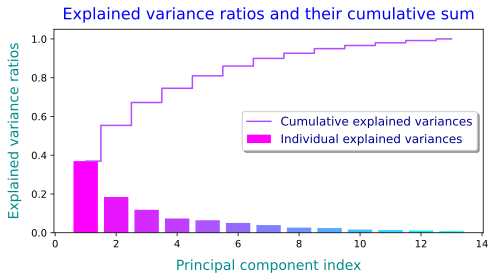

In [3]:
# Calculate the total sum of eigenvalues
tot = sum(eigen_vals)
# Calculate the explained variance for each principal component, sorted from the first to the last
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
# Calculate the cumulative explained variance
cum_var_exp = np.cumsum(var_exp)

# Create a bar plot for the individual explained variances
plt.figure(figsize=(7,4))
plt.title("Explained variance ratios and their cumulative sum", fontsize=16, color='blue', pad=10)
colors = plt.get_cmap("cool")(np.linspace(1, 0, X_train.shape[1]))
plt.bar(range(1,X_train.shape[1] + 1), var_exp, align='center', color=colors, label='Individual explained variances')

# Create a step plot for the cumulative explained variances
plt.step(range(1,X_train.shape[1] + 1), cum_var_exp, where='mid', label='Cumulative explained variances', color=cmap(0.7))
plt.ylabel("Explained variance ratios", labelpad=10, fontsize=14, color='darkcyan')
plt.xlabel("Principal component index", labelpad=10, fontsize=14, color='darkcyan')
plt.legend(loc='best', fancybox=True, shadow=True, fontsize=12, labelcolor='darkblue')
plt.tight_layout()
plt.show()

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Now that we know the eigenvalues and their corresponding eigenvectors, we sort them by descending order, construct a <font color='#cc33ff'>projection matrix</font> from the selected eigenvectors, and use the <font color='#cc33ff'>projection matrix</font> to transform the data onto a lower-dimensional subspace. We will use only the first two eigenvectors for the purpose of illustration; we’ll later visualize the result in a 2D scatterplot.<br>$\quad$
        In practice, the number of <font color='#cc33ff'>principal components</font> has to be determined by a tradeoff between computational efficiency and the performance of the classifier :

In [4]:
# creates a list of tuples, where each tuple contains an eigenvalue (eigen_vals[i]) and its
# corresponding eigenvector (eigen_vecs[:, i])
eigen_pairs = [(eigen_vals[i], eigen_vecs[:, i]) for i in range(len(eigen_vals))]
# in Python, a lambda function is a small anonymous function. In this case, 'lambda k: k[0]' defines a
# function that takes an argument k and returns its first element (k[0]). So
# 'eigen_pairs.sort(key=lambda k: k[0], reverse=True)' sorts 'eigen_pairs' in decreasing order of
# their first elements
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

# 'eigen_pairs[0][1]' returns the eigenvector associated with the first eigenvalue;
# xi_1 = 'eigen_pairs[0][1][:, np.newaxis]' transforms it into a 13x1 matrix, ie a column vector
# xi_2 = 'eigen_pairs[1][1][:, np.newaxis]' is the 13x1 matrix composed of the components of the
# second principal component
# 'np.hstack((xi_1, xi_2))' is the 13x2 matrix whose i-th column is xi_i
W = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
print(BB + "Matrix W:\n" + MB, W)

Matrix W:
 [[-0.13724218 -0.50303478]
 [ 0.24724326 -0.16487119]
 [-0.02545159 -0.24456476]
 [ 0.20694508  0.11352904]
 [-0.15436582 -0.28974518]
 [-0.39376952 -0.05080104]
 [-0.41735106  0.02287338]
 [ 0.30572896 -0.09048885]
 [-0.30668347 -0.00835233]
 [ 0.07554066 -0.54977581]
 [-0.32613263  0.20716433]
 [-0.36861022  0.24902536]
 [-0.29669651 -0.38022942]]


<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Our new matrix, <font color='#1aabff'>$X^{(2)}$</font>, is given by

In [5]:
X_train_pca = X_train_std @ W
print(BB + "The new first instance is :" + MB, X_train_pca[0])

The new first instance is : [ 2.38299011 -0.45458499]


<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Let’s visualize the transformed wine training dataset <font color='#1aabff'>$X^{(2)}$</font>, which is a matrix of dimension $124 \times 2$, in a two-dimensional scatterplot :

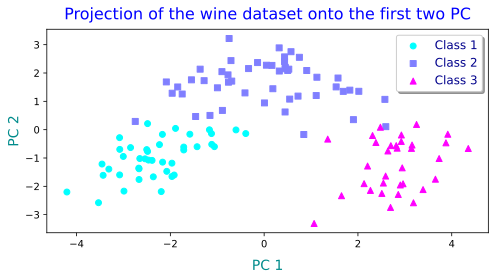

In [6]:
plt.figure(figsize=(7, 4))
plt.title("Projection of the wine dataset onto the first two PC", fontsize=16, color='blue', pad=10)
colors = [cmap(0), cmap(0.5), cmap(0.999)]
markers = ['o', 's', '^']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==l, 0], X_train_pca[y_train==l, 1], color=c, label=f'Class {l}',
                marker=m)
plt.xlabel('PC 1', labelpad=10, fontsize=14, color='darkcyan')
plt.ylabel('PC 2', fontsize=14, color='darkcyan')
plt.legend(loc='best', fancybox=True, shadow=True, fontsize=12, labelcolor='darkblue')
plt.tight_layout()
plt.show()

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        As we can see, the data is more spread along the first principal component ($x$ axis) than the second principal component ($y$ axis), which is consistent with the <font color='#cc33ff'>explained variance ratio</font> plot that we created in cell 3. However, we can tell that a linear classifier will likely be able to separate the classes well.<br>$\quad$
        In the preceding scatterplot, we encoded the class label information for the purpose of illustration. But, as we have seen, <font color='#cc33ff'>PCA</font> doesn’t use any class label information; it is an unsupervised technique.

<br><br><div style="font-family: Arial; font-size: 14px; color: darkblue">
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>1d. Principal Component Analysis in scikit-learn</font><a id="1d"></a></p>$\quad$
        Now that we understand how <font color='#cc33ff'>PCA</font> works and the role of <font color='#cc33ff'>explained variance ratios</font>, let's use the corresponding implementation in <font color='#cc33ff'>scikit-learn</font>.<br>$\quad$
        <font color='#cc33ff'>scikit-learn</font>’s <font color='#cc33ff'>PCA(n_components=<font color='#1aabff'>$d$</font>)</font> class can compute the <font color='#1aabff'>$d$</font> first principal components of the standardized dataset (via the <font color='#cc33ff'>.fit()</font> method); project the training and test sets on the subspace generated by these principal components (via <font color='#cc33ff'>.transform()</font>; as usual we may compose these methods on the training set using <font color='#cc33ff'>.fit_transform()</font>); and return the <font color='#cc33ff'>explained variance ratios</font> (via the <font color='#cc33ff'>.explained_variance_ratio_</font> attribute).<br>
    Note that the default value for <font color='#1aabff'>$d$</font> is <font color='#5555ff'>None</font>, which is the same as using <font color='#1aabff'>$\,d=n\,$</font>, and is equivalent to asking <font color='#cc33ff'>scikit-learn</font> to use all the principal components.<br>$\quad$
        We standardized the <font color='#cc33ff'>wine dataset</font> in cell 2; we called the result <font color='#5555ff'>X_train_std</font>. We will now use it to fit and transform a <font color='#cc33ff'>PCA</font> class, then classify the transformed examples via logistic regression, and finally visualize the <font color='#cc33ff'>decision regions</font> using the <font color='#5555ff'>plot_decision_regions</font> function of part 3 (coded in cell 8 there, and copy/pasted here, also cell 8).

In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
print(BB + "Explained variance ratios :\n" + MB, pca.explained_variance_ratio_)
print(BB + "Cumulative sums of the explained variance ratios :\n" + MB,
      np.cumsum(pca.explained_variance_ratio_))

Explained variance ratios :
 [0.36951469 0.18434927 0.11815159 0.07334252 0.06422108 0.05051724
 0.03954654 0.02643918 0.02389319 0.01629614 0.01380021 0.01172226
 0.00820609]
Cumulative sums of the explained variance ratios :
 [0.36951469 0.55386396 0.67201555 0.74535807 0.80957914 0.86009639
 0.89964293 0.92608211 0.9499753  0.96627144 0.98007165 0.99179391
 1.        ]


<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        It appears that we need $9$ <font color='#cc33ff'>principal components</font> to <font color='darkpink'>capture $95\%$ of the total variance</font> (ie to get a variance ratio of $95\%$), which is only slightly fewer than the original $13$.<br>$\quad$
        We now project onto the $2$-dimensional space generated by our first two <font color='#cc33ff'>principal components</font> in order to represent the data points and visualize the decision regions that we can get with $2$ <font color='#cc33ff'>principal components</font>. First, we reload our <font color='#5555ff'>plot_decision_regions</font> function.

In [8]:
def plot_decision_regions(X, y, classifier, resolution=0.02, test_idx=None):
    # 'np.unique' collects the different values in an array and returns them in ascending order without
    # repetition
    num_classes = len(np.unique(y))
    # all notations below are mine
    markers = ('o', 's', '^', 'v', '>')
    # instead of the colors in the book, which are colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    # I will use the "cool" cmap, because these colors are nicer and we can distinguish them better
    cmap = plt.get_cmap("cool")
    colors = [cmap(i / (num_classes - 1)) for i in range(num_classes)]
    cmap = ListedColormap(colors[:num_classes])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    # 'np.arange(x1_min, x1_max, resolution)' generates a 1-dimensional array with values ranging from
    # x1_min to x1_max with a step size of 'resolution'. Here this represents the set of coordinates
    # along the first dimension.
    # 'np.arange(x2_min, x2_max, resolution)' does the same for the second dimension
    # at last, if x and y are 1d arrays of dim m and n resp. then 'np.meshgrid' returns two 2d arrays
    # of dimensions n*m : the first is composed of n rows of x, and the second is composed of m 
    # columns of y
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    # the 'ravel()' method flattens any 2d array into a 1d array by writing its rows one after the 
    # other from top to bottom so 'np.array([xx1.ravel(), xx2.ravel()]).T' is a 2d array of
    # dim mn*2 whose m first rows are the coordinates of all the points of ordinate x2_min with their
    # abscissae in ascending order, the following m rows are the coordinates of all the points of
    # ordinate x2_min + resolution with their abscissae in ascending order, etc.
    # so 'lab' is a 1d array of dim mn; its first m elements are the predictions for the m points of
    # ordinate x2_min, the m following elements are the predictions for the m points of ordinate
    # x2_min + resolution, etc.
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    # now 'lab' is the n*m array of predictions for the coordinates of the points in the grid; the
    # second row (from the top) of 'lab' corresponds to the predictions for the second row (from the
    # top as well) of the grid because on a computer screen ascending ordinates go from top to bottom
    lab = lab.reshape(xx1.shape)
    # 'plt.contourf(X, Y, Z, cmap=None, alpha=None)' has many other optional parameters. It traces a
    # contour based on a grid whose coordinates are referenced by 'X' and 'Y' (here 'xx1' and 'xx2')
    # such that to each point on the grid is associated a value given by 'Z'; according to its value
    # each point is given a color defined by the colormap 'cmap' earlier defined and a transparency
    # 'alpha'. Note that 'plt.contourf' does colorize the entire grid, not only a contour ( the "f"
    # in "contourf" means "filled")
    plt.contourf(xx1, xx2, lab, cmap=cmap, alpha=0.8)
    # I add a contour to make the decision boundaries between regions clearer
    plt.contour(xx1, xx2, lab, levels=np.arange(-0.5, num_classes-0.5, 1), colors="darkblue")
    # sets the x-axis limits of the plot to span from the minimum value of the array xx1 to the
    # maximum value of xx1. 
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    # 'np.unique(y)' is defined above; 'enumerate' iterates over the array and returns the pairs
    # index/value
    for idx, cl in enumerate(np.unique(y)):
        #* X[y == cl, 0] is the first column of the sub-array of 'X' composed of the rows
        # corresponding to the class 'cl'
        #* x=X[y == cl, 0], y=X[y == cl, 1] are the coordinates of the points to be plotted
        #* c=colors[idx] : each point should receive the color corresponding to its index 'idx'
        #* marker=markers[idx] : each point should receive the marker style registered at
        # 'markers[idx]'
        #* label=f"Class {cl}" defines a label for all the points corresponding to the current class
        # 'cl'; it will be used in the legend of the plot.
        #* edgecolor='black' : the color of the markers' edges will be black
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], color=colors[idx], alpha=0.6, marker=markers[idx],
                    label=f"Class {cl}", edgecolor='black')
    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]
        #* 'linewidth=1' means that the lines are 1 point in width, a point being of size 1/72 inch
        #* 's' is the surface area of a square bounding the marker, so here the markers are bounded by
        # squares of side length 10/72 inch 
        plt.scatter(X_test[:, 0], X_test[:, 1], c='none', edgecolor='black', alpha=0.8, linewidth=1,
                    marker='o', s=100, label="Test set")

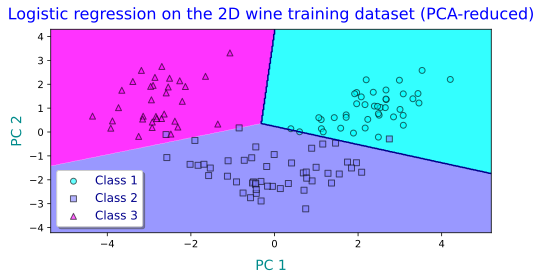

In [9]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
# initializing the PCA transformer and logistic regression estimator:
pca = PCA(n_components=2)
lr = OneVsRestClassifier(LogisticRegression(random_state=1, solver='lbfgs'))
# dimensionality reduction:
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
# fitting the logistic regression model on the reduced dataset:
lr.fit(X_train_pca, y_train)

plt.figure(figsize=(7, 4))
plt.title("Logistic regression on the 2D wine training dataset (PCA-reduced)", fontsize=16, color='blue', pad=10)
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1', labelpad=10, fontsize=14, color='darkcyan')
plt.ylabel('PC 2', labelpad=5, fontsize=14, color='darkcyan')
plt.legend(loc='lower left', fancybox=True, shadow=True, fontsize=12, labelcolor='darkblue')
plt.tight_layout()
plt.show()

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Let’s plot the <font color='#cc33ff'>decision regions</font> of the <font color='#cc33ff'>logistic regression</font> on the transformed test dataset to check if it can separate the classes well :

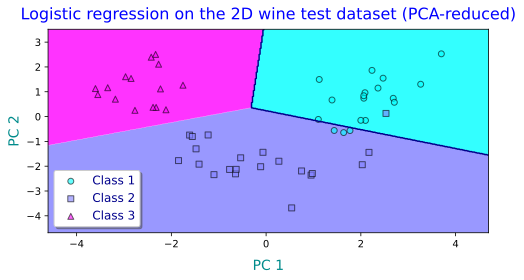

In [10]:
plt.figure(figsize=(7, 4))
plt.title("Logistic regression on the 2D wine test dataset (PCA-reduced)", fontsize=16, color='blue', pad=10)
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC 1', labelpad=10, fontsize=14, color='darkcyan')
plt.ylabel('PC 2', labelpad=5, fontsize=14, color='darkcyan')
plt.legend(loc='lower left', fancybox=True, shadow=True, fontsize=12, labelcolor='darkblue')
plt.tight_layout()
plt.show()

<a id="2"></a><br><br><br><div style="font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">
    <h4 style="margin: 0 0 .5rem 2rem; font-size: 18px; font-weight: 800"><font color='darkpink'>2. LINEAR DISCRIMINANT ANALYSIS</font></h4>
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>2a. Presentation</font><a id="2a"></a></p>$\quad$
        Like <font color='#cc33ff'>PCA (Principal Component Analysis)</font>, <font color='darkpink'>LDA</font> (<font color='darkpink'>Linear Discriminant Analysis</font>) is a linear transformation technique that can be used to reduce the number of dimensions in a dataset. But, whereas <font color='#cc33ff'>PCA</font> attempts to find the orthogonal component axes of maximum variance in a dataset, the goal in <font color='#cc33ff'>LDA</font> is to find the feature subspace that optimizes class separability. Thus, the former is an <font color='#cc33ff'>unsupervised algorithm</font>, whereas the latter is <font color='#cc33ff'>supervised</font>.<br>$\quad$
        In the following diagram a <font color='#cc33ff'>PCA algorithm</font> would be happy to use the vertical axis (passing between the ellipses) as its first principal component because it would be the closest to the data points, this axis would not be suitable for the <font color='#cc33ff'>LDA technique</font>, which would rather choose the horizontal axis because projecting on the horizontal axis would best separate the two classes of points.

<figure style="text-align: center;">
    <img src="5.2. The concept of LDA for a two-class problem.png" alt="The diagram shows two disjoint vertical ellipses, each containing exactly one class: the ellipse on the left contains the circles and the one on the right contains the plus signs. Because they're vertical PCA would project onto the y-axis, mixing the circles and pluses, whereas LDA would project onto the x-axis, keeping them cleanly separated." width="300" />
    <figcaption style="margin-top: .5rem; font-weight: bold; color: purple">The concept of LDA for a two-class problem</figcaption>
</figure>

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        <font color='purple'><font color='#cc33ff'>LDA</font> relies on several assumptions :</font> that <font color='purple'>the data is normally distributed</font>, that <font color='purple'>the classes have identical covariance matrices, and</font> that <font color='purple'>the training examples are statistically independent of each other</font>. However, even if one, or more, of those assumptions is slightly violated, <font color='#cc33ff'>LDA</font> can still work reasonably well for dimensionality reduction.<br><br>
    <p style="margin: 0 0 0 2rem; font-size: 15px; font-weight: 600"><font color='purple'>$\quad$Note :</font></p>$\quad$
        In his rather complete book "Hands-On Machine Learning" (ed O'Reilly, 2023, 1199p.), A. Géron only devotes 7 lines to this subject (in "Other dimensionality reduction techniques", p.338), and the author we follow, S. Raschka, only quotes articles dating back to 2001 or earlier, so I will not present the technique in detail, just summarize what is in the book.

<br><br><div style="font-family: Arial; font-size: 14px; color: darkblue">
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>2b. The LDA algorithm</font><a id="2b"></a></p>$\quad$
        As usual, we start with a training matrix <font color='#1aabff'>$X$</font> $\in \mathbb{R}^{m \times n}$, which contains <font color='#1aabff'>$\,m\,$</font> instances (rows) <font color='#1aabff'>$\,x^{(i)}\,$</font> and <font color='#1aabff'>$\,n\,$</font> features <font color='#1aabff'>$\,X_j\,$</font>. We suppose that the instances belong to classes, and we denote by <font color='#1aabff'>$\,K\,$</font> the number of classes. Then, for any $\,k=1, \cdots, K\,$, <font color='#1aabff'>$\,C_k\,$</font> denotes the set of instances in the <font color='#1aabff'>$k$</font>-th class, <font color='#1aabff'>$\,I_k\,$</font> denotes the subset of $\{1, \cdots, m\}$ composed of the indices of the instances belonging to <font color='#1aabff'>$C_k$</font>, and <font color='#1aabff'>$\,m_k\,$</font> denotes the number of instances in the $k$-th class, ie the cardinal of $C_k$. We successively define :<br>
* for each class $\,k = 1, \cdots, K\;$ the <font color='darkpink'>mean of the class $C_k$</font> is the $\mathbb{R}^n$-vector<div style="margin-top: 10px"></div><font color='purple'>
    $$\mu_k \;=\; \frac{1}{m_k} \,\sum_{l \in I_k}\, x^{(l)} \qquad\quad (23)$$</font><div style="margin-top: 10px"></div><br>
* the <font color='darkpink'>mean of the instances</font> is the $\mathbb{R}^n$-vector<div style="margin-top: 10px"></div><font color='purple'>
    $$\mu \;=\; \frac{1}{m} \;\sum_{i=1}^{m} x^{(i)} \;=\; \frac{1}{m} \;\sum_{k=1}^{K} \,m_k \; \mu_k \qquad\quad (24)$$</font><div style="margin-top: 10px"></div><br>
* for each class $\,k = 1, \cdots, K\;$ the <font color='darkpink'>scatter matrix of the class $C_k$</font> is the $\mathbb{R}^{n \times n}$-matrix<div style="margin-top: 10px"></div><font color='purple'>
    $$S_k \;=\; \sum_{l \in I_k} \left(x^{(l)}-\mu_k\right)^T \, \left(x^{(l)}-\mu_k\right) \qquad\quad (25)$$</font><div style="margin-top: 10px"></div><br>
* the <font color='darkpink'>within-class scatter matrix</font> is the $\mathbb{R}^{n \times n}$-matrix<div style="margin-top: 10px"></div><font color='purple'>
    $$S_W \;=\; \sum_{k=1}^{K} S_k \qquad\quad (26)$$</font><div style="margin-top: 10px"></div><br>
* the <font color='darkpink'>between-class scatter matrix</font> is the $\mathbb{R}^{n \times n}$-matrix<div style="margin-top: 10px"></div><font color='purple'>
    $$S_B \;=\; \sum_{k=1}^{K} m_k \, \left(\mu_k - \mu\right)^T \, \left(\mu_k - \mu\right) \qquad\quad (27)$$

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        The <font color='#cc33ff'>LDA algorithm</font> consists in performing the following tasks :<font color='purple'><ol>
<li>Standardize the training matrix <font color='#1aabff'>$X$</font> <font color='darkblue'>(see part 4, "3b. Bringing features onto the same scale")</font></li>
<li>For each class, compute the $n$-dimensional mean vector <font color='#1aabff'>$\,\mu_k$</font>; then compute <font color='#1aabff'>$\mu$</font></li>
<li>Construct the <font color='#cc33ff'>within-class scatter matrix</font> <font color='#1aabff'>$\,S_W\,$</font> and the <font color='#cc33ff'>between-class scatter matrix</font> <font color='#1aabff'>$\,S_B$</font></li>
<li>Solve the <font color='darkpink'>generalized eigenvalue problem for the matrix pair</font> <font color='#1aabff'>$(S_B, S_W)$</font>, i.e. find scalars <font color='#1aabff'>$\lambda$</font> and non-zero vectors <font color='#1aabff'>$\xi$</font> such that<font color='purple'>
    $$S_B \, \xi \;=\; \lambda \, S_W \, \xi \qquad\quad (28)$$</li>
<li>Sort the <font color='#cc33ff'>generalized eigenvalues</font> <font color='#1aabff'>$\lambda$</font> by decreasing order to rank the corresponding <font color='#cc33ff'>generalized eigenvectors</font> <font color='#1aabff'>$\xi$</font></li>
<li>Select the $\,d\,$ <font color='#cc33ff'>generalized eigenvectors</font> that correspond to the $\,d\,$ largest <font color='#cc33ff'>generalized eigenvalues</font> to construct a $(n \!\times\! d)$ transformation matrix, <font color='darkpink'>$\,W\,$</font>, whose <font color='#1aabff'>$k$</font>-th column is the <font color='#1aabff'>$k$</font>-th <font color='#cc33ff'>generalized eigenvector</font></li>
<li>The <font color='#cc33ff'>generalized eigenvectors</font> generate the new <font color='#cc33ff'>feature subspace</font>; project the instances onto it using <font color='#1aabff'>$W$</font> : the new training matrix is <font color='darkpink'>$\; X_{new} \,=\, X \, W$</li></ol>
        As we can see, <font color='#cc33ff'>LDA</font> is quite similar to <font color='#cc33ff'>PCA</font> in the sense that we are decomposing matrices into (generalized) <font color='#cc33ff'>eigenvalues</font> and <font color='#cc33ff'>eigenvectors</font>, which will form the new lower-dimensional <font color='#cc33ff'>feature space</font>. However, as mentioned above, <font color='#cc33ff'>LDA</font> takes class label information into account, which is represented in the form of the mean vectors computed in step 2.

<br><br><div style="font-family: Arial; font-size: 14px; color: darkblue">
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>2c. Coding Linear Discriminant Analysis</font><a id="2c"></a></p>$\quad$
        In this section, we will code the <font color='#cc33ff'>LDA dimensionality reduction algorithm</font> using the <font color='#cc33ff'>wine dataset</font> as an example. The task will be somewhat simplified because the <font color='#cc33ff'>wine dataset</font> has an invertible within-class scatter matrix <font color='#1aabff'>$\,S_W\,$</font>, and the matrix $\,S_W^{-1}\,S_B\,$ is diagonalizable.<br>$\quad$
        The first step of the algorithm, "Standardize the training matrix $X$" has already been done in cell 2. So now we do the second step, "compute the $n$-dimensional mean vectors" :

In [11]:
# set the precision for printing NumPy floats to 4 decimal places
np.set_printoptions(precision=4)
mean_vecs = []
# there are only 3 classes in the wine dataset
for label in range(1,4):
    # compute the mean of the instances of class 'label'
    mean_vecs.append(np.mean(X_train_std[y_train==label], axis=0))
    print(BB + "Mean Vector", label, ":" + MB, mean_vecs[label - 1], "\n")

Mean Vector 1 : [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075] 

Mean Vector 2 : [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253] 

Mean Vector 3 : [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013] 



<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        We can now compute the <font color='#cc33ff'>within-class scatter matrix</font> <font color='#1aabff'>$S_W$</font>, the <font color='#cc33ff'>between-class scatter matrix</font> <font color='#1aabff'>$S_B$</font>, and then <font color='#1aabff'>$\,S_{W}^{-1} \, S_B$</font> :

In [12]:
# there are 13 features in the wine dataset
n = 13

# compute S_W
S_W = np.zeros((n, n))
for label, mv in zip(range(1, 4), mean_vecs):
    # compute the scatter matrix of the 'label' class
    class_scatter = np.zeros((n, n))
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(1, n), mv.reshape(1, n)
        class_scatter += (row - mv).T @ (row - mv)
    S_W += class_scatter

# compute the mean of the instances
mean_overall = np.mean(X_train_std, axis=0).reshape(1,n)

# compute S_B
S_B = np.zeros((n, n))
for k in range(3):
    m_k = X_train_std[y_train == k + 1, :].shape[0]
    S_B += m_k * (mean_vecs[k] - mean_overall).T @ (mean_vecs[k] - mean_overall)

# compute Z := inv(S_W) @ S_B
Z = np.linalg.inv(S_W) @ S_B

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        The eigenvectors of $\,S_{W}^{-1} \, S_B\,$ are called the <font color='darkpink'>linear discriminants</font>.<br>$\quad$
        We compute the <font color='#cc33ff'>eigenvalues</font> and their corresponding <font color='#cc33ff'>eigenvectors</font>; we replace the <font color='#cc33ff'>eigenvalues</font> with their absolute values and rank the pairs in descending order. We see that the third <font color='#cc33ff'>eigenvalue</font> is already almost $0$; this is why I only give the value of the first three.

In [13]:
eigen_vals, eigen_vecs = np.linalg.eig(Z)
eigen_pairs = [(np.abs(eigen_vals[j]), eigen_vecs[:,j]) for j in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)
print(BB + "The first absolute values of the eigenvalues in descending order:" + MB)
for eigen_val in eigen_pairs[:3]:
    print(eigen_val[0])

The first absolute values of the eigenvalues in descending order:
8.262493673957483
4.225659486916683
8.53535112244138e-16


<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Consequently the "Explained variance ratios and their cumulative sum" plot that we created in the PCA section (cell 3) is of little interest here : the first two linear discriminants alone capture 100 percent of the useful information in the wine training dataset. The author plotted it anyway, so we may use the code in another context. The ability of a method (like <font color='#cc33ff'>LDA</font>) to differentiate between distinct classes in a dataset is called <font color='darkpink'>discriminability</font> :

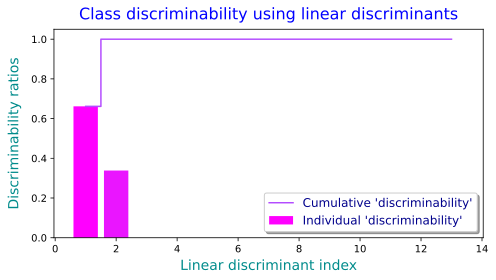

In [14]:
# Calculate the total sum of eigenvalues
tot = sum(eigen_vals.real)
# Calculate the explained variance for each linear discriminant, sorted from the first to the last
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
# Calculate the cumulative explained variance
cum_discr = np.cumsum(discr)

# Create a bar plot for the individual explained variances
plt.figure(figsize=(7, 4))
plt.title("Class discriminability using linear discriminants", fontsize=16, color='blue', pad=10)
colors = plt.get_cmap("cool")(np.linspace(1, 0, X_train.shape[1]))
plt.bar(range(1,X_train.shape[1] + 1), discr, align='center', color=colors, label="Individual 'discriminability'")

# Create a step plot for the cumulative explained variances
plt.step(range(1,X_train.shape[1] + 1), cum_discr, where='mid', label="Cumulative 'discriminability'", color=cmap(0.7))
plt.ylabel("Discriminability ratios", labelpad=10, fontsize=14, color='darkcyan')
plt.xlabel("Linear discriminant index", labelpad=5, fontsize=14, color='darkcyan')
plt.legend(loc='best', fancybox=True, shadow=True, fontsize=12, labelcolor='darkblue')
plt.tight_layout()
plt.show()

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
    We can now create the transformation matrix <font color='#1aabff'>$\,W\,$</font>; it is composed of the two <font color='#cc33ff'>linear discriminants</font> corresponding to the two eigenvalues that are significantly greater than $0$ :

In [15]:
W = np.hstack((eigen_pairs[0][1][:, np.newaxis].real, eigen_pairs[1][1][:, np.newaxis].real))
print(BB + 'Matrix W:\n' + MB, W)

Matrix W:
 [[-0.1586 -0.4077]
 [ 0.0984 -0.1821]
 [-0.0156 -0.3473]
 [ 0.1588  0.3095]
 [-0.0207 -0.064 ]
 [ 0.1884  0.0733]
 [-0.7153  0.3034]
 [-0.0798 -0.0009]
 [ 0.0074  0.0716]
 [ 0.3448 -0.2808]
 [-0.0254  0.244 ]
 [-0.3192 -0.0459]
 [-0.4054 -0.5806]]


<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
    We can now project the <font color='#cc33ff'>wine dataset</font> onto the $2$-dimensional vector space generated by the two <font color='#cc33ff'>linear discriminants</font> we have just found. We see that the three wine classes are perfectly linearly separable in the new feature subspace (note : in the diagram, I write "LD" for, well, I suppose you'll guess it) :

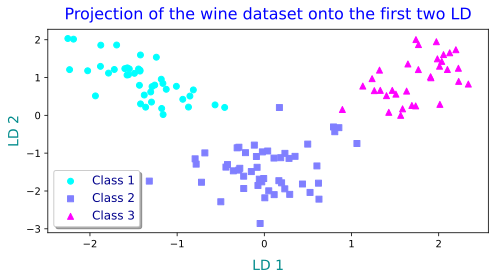

In [16]:
X_train_lda = X_train_std.dot(W)

plt.figure(figsize=(7, 4))
plt.title("Projection of the wine dataset onto the first two LD", fontsize=16, color='blue', pad=10)
colors = [cmap(0), cmap(0.5), cmap(0.999)]
markers = ['o', 's', '^']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train==l, 0], X_train_lda[y_train==l, 1] * (-1), color=c,
                label= f'Class {l}', marker=m)
plt.xlabel('LD 1', labelpad=10, fontsize=14, color='darkcyan')
plt.ylabel('LD 2', labelpad=5, fontsize=14, color='darkcyan')
plt.legend(loc='lower left', fancybox=True, shadow=True, fontsize=12, labelcolor='darkblue')
plt.tight_layout()
plt.show()

<br><br><div style="font-family: Arial; font-size: 14px; color: darkblue">
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>2d. Linear Discriminant Analysis in scikit-learn</font><a id="2d"></a></p>$\quad$
        In <font color='#cc33ff'>scikit-learn</font>, <font color='#cc33ff'>LDA</font> is implemented under the class <font color='#cc33ff'>LinearDiscriminantAnalysis</font> of the <font color='#cc33ff'>discriminant_analysis</font> module.<br>$\quad$
        First, we compute the <font color='#cc33ff'>cumulative explained variance ratios</font> in order to decide how many linear discriminants we want to use :

In [17]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=None)
X_train_lda = lda.fit_transform(X_train_std, y_train)
print(BB + "Explained variance ratios :\n" + MB, lda.explained_variance_ratio_)
print(BB + "Cumulative sums of explained variance ratios :\n" + MB,
      np.cumsum(lda.explained_variance_ratio_))

Explained variance ratios :
 [0.6616 0.3384]
Cumulative sums of explained variance ratios :
 [0.6616 1.    ]


<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Since there are only two non-zero <font color='#cc33ff'>eigenvalues</font>, it is no wonder that only $2$ <font color='#cc33ff'>explained variance ratios</font> are relevant. This is much better than what we got with the PCA algorithm, where we needed $9$ principal components to <font color='#cc33ff'>capture $95\%$ of the total variance</font> (see "1d. Principal Component Analysis in scikit-learn").<br>$\quad$
        So our choice for the two features to use to visualize the <font color='#cc33ff'>decision regions</font> in 2D is enforced here : we transform our training matrix by projecting its instances onto the two dimensional subspace generated by the two relevant <font color='#cc33ff'>linear discriminants</font>; then we perform a <font color='#cc33ff'>logistic regression</font> to separate the classes linearly; and then we draw the corresponding <font color='#cc33ff'>decision regions</font>. At last, we test our results using the test dataset.

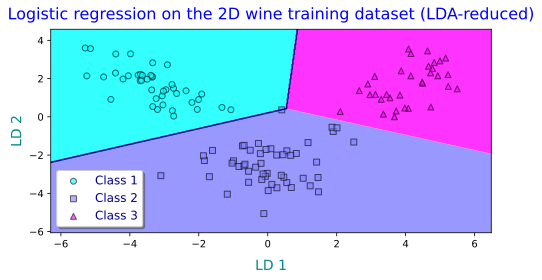

In [18]:
# initializing the LDA transformer and logistic regression estimator:
lda = LDA(n_components=2)
# C=1.0 is the default, although we would get a slightly better result if we use
# C=0.05 instead
lr = OneVsRestClassifier(LogisticRegression(C=1, random_state=1, solver='lbfgs'))
# dimensionality reduction:
X_train_lda = lda.fit_transform(X_train_std, y_train)
X_test_lda = lda.transform(X_test_std)
# fitting the logistic regression model on the reduced dataset:
lr.fit(X_train_lda, y_train)

plt.figure(figsize=(7, 4))
plt.title("Logistic regression on the 2D wine training dataset (LDA-reduced)", fontsize=16, color='blue', pad=10)
plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1', labelpad=10, fontsize=14, color='darkcyan')
plt.ylabel('LD 2', labelpad=5, fontsize=14, color='darkcyan')
plt.legend(loc='lower left', fancybox=True, shadow=True, fontsize=12, labelcolor='darkblue')
plt.tight_layout()
plt.show()

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        We can see that the <font color='#cc33ff'>logistic regression model</font> misclassifies one of the examples from class $2$. By augmenting the regularization strength (ie by decreasing the value of <font color='#cc33ff'>C</font>, see part 3, "2g. Overfitting and regularized linear models"), we could shift the decision boundaries so that the logistic regression model classifies all examples in the training dataset correctly (eg, if we use the hyperparameter <font color='#1aabff'>C=0.05</font> then all instances of the training dataset are correctly classified). However, the results are already excellent, so there is no need to improve on the training accuracy, and we would risk <font color='#cc33ff'>overfitting</font>... More importantly, let’s take a look at the results on the test dataset :

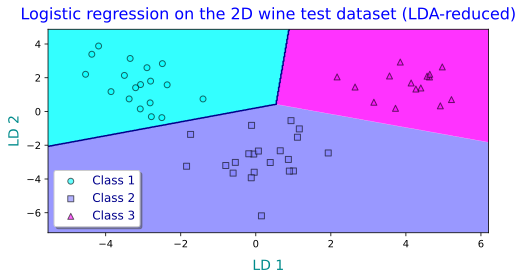

In [19]:
plt.figure(figsize=(7, 4))
plt.title("Logistic regression on the 2D wine test dataset (LDA-reduced)", fontsize=16, color='blue', pad=10)
plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1', labelpad=10, fontsize=14, color='darkcyan')
plt.ylabel('LD 2', labelpad=5, fontsize=14, color='darkcyan')
plt.legend(loc='lower left', fancybox=True, shadow=True, fontsize=12, labelcolor='darkblue')
plt.tight_layout()
plt.show()

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        As we can see, <font color='magenta'>the logistic regression classifier is able to get a perfect test accuracy score by only using a two-dimensional subspace, instead of the original 13 wine features.</font><br>
    Note that, with <font color='#1aabff'>C=0.05</font>, we would get $100\%$ training and test accuracy scores.

<a id="3"></a><br><br><br><div style="font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">
    <h4 style="margin: 0 0 .5rem 2rem; font-size: 18px; font-weight: 800"><font color='darkpink'>3. NONLINEAR DIMENSIONALITY REDUCTION</font></h4>
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>3a. Presentation</font><a id="3a"></a></p>$\quad$
        When we tackle nonlinear problems, which we may encounter rather frequently in real-world applications, linear transformation techniques for dimensionality reduction, such as <font color='#cc33ff'>PCA</font> and <font color='#cc33ff'>LDA</font>, may not be the best choice.<br>$\quad$
        <font color='#cc33ff'>scikit-learn</font> implements a selection of advanced techniques for nonlinear dimensionality reduction that are beyond the scope of this book. The interested reader can find a nice overview of the current implementations in <font color='#cc33ff'>scikit-learn</font>, complemented with illustrative examples, at https://scikit-learn.org/stable/modules/manifold.html<br>$\quad$
        The development and application of nonlinear dimensionality reduction techniques is also often referred to as <font color='darkpink'>manifold learning</font>, where "manifold" has its usual meaning of a <font color='#cc33ff'>topological space embedded in a higher-dimensional space</font>. A classic example of <font color='#cc33ff'>manifold learning</font> is the $3$-dimensional Swiss roll illustrated in the following figure :

<figure style="text-align: center;">
    <img src="5.3. 3D Swiss roll projections.png" alt="The diagram shows a 3D Swiss roll from three different angles, in black and white, with classes differentiated by intensity of blackness (we cannot see them clearly). Below, two possible reductions in 2D are presented, one good and one bad." width="500" />
    <figcaption style="margin-top: .5rem; font-weight: bold; color: purple">Two 2D reductions of a 3D Swiss roll: one successful, one not.</figcaption>
</figure>

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        While <font color='#cc33ff'>nonlinear dimensionality reduction</font> and <font color='#cc33ff'>manifold learning algorithms</font> may be very powerful, we should note that these techniques are notoriously hard to use and, with non-ideal hyperparameter choices, they may cause more harm than good. The reason behind this difficulty is that we are often working with high-dimensional datasets that we cannot readily visualize and where the structure is not obvious (unlike the Swiss roll example in Figure 5.14). Moreover, unless we project the dataset into two or three dimensions (which is often not sufficient for capturing more complicated relationships), it is hard or even impossible to assess the quality of the results. Hence, simpler techniques such as <font color='#cc33ff'>PCA</font> and <font color='#cc33ff'>LDA</font> for <font color='#cc33ff'>dimensionality reduction</font> are generally preferred.

<br><br><div style="font-family: Arial; font-size: 14px; color: darkblue">
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>3b. Example : the t-SNE and UMAP on the Digits dataset</font><a id="3b"></a></p>$\quad$
        The <font color='darkpink'>t-Distributed Stochastic Neighbor Embedding</font> (<font color='darkpink'>t-SNE</font>) reduces dimensionality while trying to keep similar instances close and dissimilar instances apart; in other words, t-SNE learns to embed data points into a lower-dimensional space such that the pairwise distances in the original space are preserved. It is mostly used for visualization in 2D or 3D, in particular to visualize clusters of instances in high-dimensional space (e.g. to visualize the MNIST images in 2D). Unfortunately, since it projects the points directly (unlike PCA, it does not involve a projection matrix), we cannot apply t-SNE to new data points.<br>$\quad$
        Let's apply t-SNE to the <font color='#cc33ff'>Digits</font> dataset, a $64$-dimensional set of low-resolution handwritten digits (the numbers 0-9). The digits are $\,8\!\times\!8\,$ grayscale images. The following code plots the first four images in the dataset, which consists of $1,797$ images in total, so the dataset has $1,797$ rows of instances (the images) and $64$ columns of features (the pixels) :

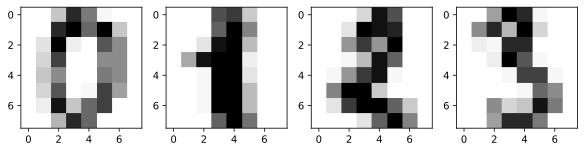

In [20]:
from sklearn.datasets import load_digits
digits = load_digits()
# there will be 4 subplots in a single row and the total figure would be 10 inches wide if printed
fig, ax = plt.subplots(1, 4, figsize=(10, 2.5))
for i in range(4):
    # displays the i-th image using a grayscale colormap
    ax[i].imshow(digits.images[i], cmap='Greys')
plt.show()

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        The <font color='#5555ff'>digits</font> dataset variable in the code has two attributes, <font color='#5555ff'>digits.data</font> and <font color='#5555ff'>digits.target</font>, which are the dataset and the corresponding labels. We call them <font color='#5555ff'>X_digits</font> and <font color='#5555ff'>y_digits</font> in the following code, where we fit a <font color='#5555ff'>tsne</font> object from the <font color='#cc33ff'>scikit-learn</font>'s <font color='#cc33ff'>TSNE</font> class of the <font color='#cc33ff'>manifold</font> module. The <font color='#5555ff'>tsne</font> object is set with <font color='#cc33ff'>n_components=</font><font color='#1aabff'>2</font> to get a <font color='#1aabff'>2</font>D representation, and initialized with <font color='#cc33ff'>init='pca'</font>, which is the default value, and the value recommended by the author, who also recommends experimenting with the hyperparameters <font color='#cc33ff'>learning_rate</font> and <font color='#cc33ff'>perplexity</font>.<br>
    I'll let you follow S. Raschka's recommendation if you want. Just know that, according to <font color='#cc33ff'>scikit-learn</font>'s website, the ideal <font color='#cc33ff'>learning_rate</font> is usually in the range $[10.0, 1000.0]$. And the <font color='#cc33ff'>perplexity</font> is "related to the number of nearest neighbors used in other manifold learning algorithms" (indeed! ^^); different values of <font color='#cc33ff'>perplexity</font> can result in significantly different results; it has a default value of $30$, and we should consider selecting a value between $5$ and $50$, with larger datasets usually requiring a larger perplexity.<br>$\quad$
        Like <font color='#cc33ff'>PCA</font>, <font color='#cc33ff'>t-SNE</font> is an unsupervised method, and we only use the class labels <font color='#5555ff'>y_digits</font> (0-9) for visualization purposes :

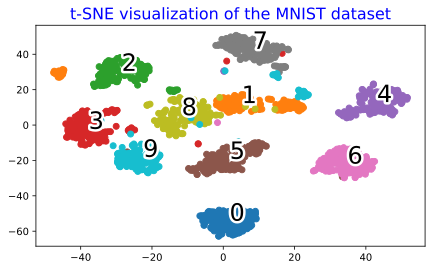

In [21]:
os.environ["LOKY_MAX_CPU_COUNT"] = str(os.cpu_count())

X_digits = digits.data
y_digits = digits.target

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, init='pca', random_state=1)
X_digits_tsne = tsne.fit_transform(X_digits)

import matplotlib.patheffects as PathEffects
# I've slightly modified the original code in order to add a title to the figures
def plot_projection(x, colors, title):
    plt.figure(figsize=(7, 4))
    plt.title(title, fontsize=16, color='blue')
    for i in range(10):
        plt.scatter(x[colors == i, 0], x[colors == i, 1])
        # Compute the median position of the instances of target value i
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = plt.text(xtext, ytext, str(i), fontsize=24)
        # Add 5 lines of white around the digit label for better visibility
        txt.set_path_effects([PathEffects.Stroke(linewidth=5, foreground="w"), PathEffects.Normal()])

plot_projection(X_digits_tsne, y_digits, title="t-SNE visualization of the MNIST dataset")
plt.show()

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        As we can see, <font color='#cc33ff'>t-SNE</font> is able to separate the different digit classes nicely, although not perfectly. It might be possible to achieve better separation by tuning the hyperparameters. However, a certain degree of class mixing might be unavoidable due to poor resolution and illegible handwriting. For instance, by inspecting individual images, we might have trouble distinguishing a "3" from a "9", and so forth.<br>$\quad$
        Another popular visualization technique is <font color='darkpink'>uniform manifold approximation and projection</font> (<font color='darkpink'>UMAP</font>). Not only can <font color='#cc33ff'>UMAP</font> produce as good results as <font color='#cc33ff'>t-SNE</font>, it is typically faster (not in this example with my potato laptop, though, which takes about three times as long). A huge advantage of <font color='#cc33ff'>UMAP</font> over <font color='#cc33ff'>t-SNE</font> is that, like <font color='#cc33ff'>PCA</font>, <font color='#cc33ff'>UMAP</font> can also be used to project new data.<br>$\quad$
        Let's try it on the <font color='#cc33ff'>Digits</font> dataset.

C:\Users\arslu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


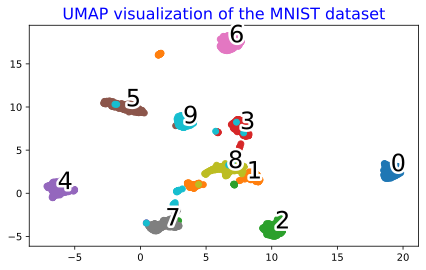

In [22]:
from umap import UMAP
umap_2d = UMAP(n_components=2, init='random')
proj_2d = umap_2d.fit_transform(X_digits)

plot_projection(proj_2d, y_digits, title="UMAP visualization of the MNIST dataset")
plt.show()

<br><span style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
    We see that the classes are more compactly grouped and more isolated, although there are still several mixed-up instances.